# SGR Startup Flow: Stress Growth and Dynamic Noise Temperature

## Learning Objectives

1. Generate synthetic startup flow data from calibrated SGR parameters
2. Fit stress growth coefficient η⁺(t) using SGRConventional
3. Explore dynamic_x mode for thixotropic noise temperature evolution
4. Visualize x(t) trajectories under different shear rates
5. Perform Bayesian inference on startup data

## Prerequisites

- Notebook 01 (flow curve calibration for synthetic parameters)
- examples/basic/01_quickstart.ipynb
- examples/bayesian/01_bayesian_inference.ipynb

## Expected Runtime

- **Fast mode** (NUM_CHAINS=1, small samples): ~2 minutes
- **Production mode** (NUM_CHAINS=4, full samples): ~5 minutes

## 1. Setup

In [1]:
import sys
IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import os
import json
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.sgr import SGRConventional, SGRGeneric

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")

JAX version: 0.8.2
Devices: [CpuDevice(id=0)]


In [3]:
def compute_fit_quality(y_true, y_pred):
    """Compute R² and RMSE."""
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    residuals = y_true - y_pred
    if y_true.ndim > 1:
        residuals = residuals.ravel()
        y_true = y_true.ravel()
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y_true - np.mean(y_true))**2)
    r2 = 1.0 - ss_res / ss_tot if ss_tot > 0 else 0.0
    rmse = np.sqrt(np.mean(residuals**2))
    return {"R2": r2, "RMSE": rmse}

## 2. Theory: SGR Startup Flow

In startup flow, a constant shear rate γ̇ is suddenly applied to a material at rest. The stress growth coefficient is:

$$
\eta^+(t) = G_0 \cdot G_0(x) \cdot \tau_0 \cdot \frac{(1 + t/\tau_0)^{x-1} - 1}{x - 1}
$$

For the special case x ≈ 1:

$$
\eta^+(t) = G_0 \cdot G_0(x) \cdot \tau_0 \cdot \ln(1 + t/\tau_0)
$$

The stress is then:

$$
\sigma(t) = \eta^+(t) \cdot \dot{\gamma}
$$

### Phase-Dependent Behavior

- **Glass (x < 1)**: η⁺ → ∞ as t → ∞ (no steady state)
- **Fluid (x > 1)**: η⁺ → η₀ (zero-shear viscosity)
- **Critical (x = 1)**: Logarithmic growth

### Dynamic Noise Temperature

With `dynamic_x=True`, the noise temperature evolves under shear:

$$
\frac{dx}{dt} = -\alpha_{\text{aging}} \cdot (x - x_{\text{eq}}) + \beta_{\text{rejuv}} \cdot \dot{\gamma} \cdot (x_{\text{ss}} - x)
$$

where:

$$
x_{\text{ss}}(\dot{\gamma}) = x_{\text{eq}} + A \cdot (\dot{\gamma} \cdot \tau_0)^n
$$

## 3. Generate Synthetic Data

Load calibrated parameters from Notebook 01 (flow curve fitting), or use default values if not available. Generate startup data at 4 shear rates with 3% Gaussian noise.

In [4]:
# Load calibrated parameters from NB 01 (or use defaults)
params_path = os.path.join("..", "outputs", "sgr", "flow_curve", "nlsq_params.json")
if os.path.exists(params_path):
    with open(params_path) as f:
        calib_params = json.load(f)
    print(f"Loaded calibrated parameters from NB 01: {calib_params}")
else:
    calib_params = {"x": 1.3, "G0": 500.0, "tau0": 1e-3}
    print(f"Using default parameters (run NB 01 first for calibrated values): {calib_params}")

# Generate clean model predictions
model_true = SGRConventional()
for name, val in calib_params.items():
    model_true.parameters.set_value(name, val)
model_true.fitted_ = True
model_true._test_mode = "startup"

gamma_dots = [0.1, 1.0, 10.0, 100.0]
t_data = np.logspace(-3, 2, 80)
rng = np.random.default_rng(42)
noise_level = 0.03

datasets = {}
for gd in gamma_dots:
    model_true._startup_gamma_dot = gd
    eta_plus_clean = np.array(model_true.predict(t_data))
    noise = 1.0 + noise_level * rng.standard_normal(len(eta_plus_clean))
    eta_plus_noisy = eta_plus_clean * noise
    eta_plus_noisy = np.maximum(eta_plus_noisy, 1e-10)  # Ensure positive
    datasets[gd] = {"t": t_data, "eta_plus": eta_plus_noisy, "eta_plus_clean": eta_plus_clean}
    print(f"γ̇={gd:6.1f}: η⁺ range [{eta_plus_noisy.min():.4g}, {eta_plus_noisy.max():.4g}] Pa·s")

Loaded calibrated parameters from NB 01: {'x': 1.0164641594061137, 'G0': 33.70749398407571, 'tau0': 16.480806500813653}


γ̇=   0.1: η⁺ range [0.02536, 815.5] Pa·s
γ̇=   1.0: η⁺ range [0.02548, 793.9] Pa·s
γ̇=  10.0: η⁺ range [0.0244, 810.1] Pa·s
γ̇= 100.0: η⁺ range [0.02447, 794.1] Pa·s


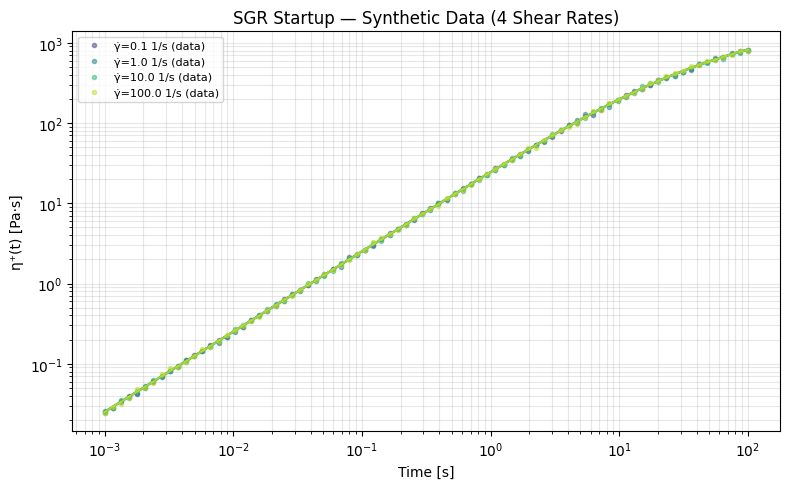

In [5]:
fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gamma_dots)))

for i, gd in enumerate(gamma_dots):
    d = datasets[gd]
    ax.loglog(d["t"], d["eta_plus"], "o", color=colors[i], markersize=3, alpha=0.5, label=f"γ̇={gd} 1/s (data)")
    ax.loglog(d["t"], d["eta_plus_clean"], "-", color=colors[i], lw=1.5, alpha=0.8)

ax.set_xlabel("Time [s]")
ax.set_ylabel("η⁺(t) [Pa·s]")
ax.set_title("SGR Startup — Synthetic Data (4 Shear Rates)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting

### 4.1 Single Shear Rate (γ̇ = 10 s⁻¹)

In [6]:
model = SGRConventional()

gd_fit = 10.0
d = datasets[gd_fit]

t0_fit = time.time()
model.fit(d["t"], d["eta_plus"], test_mode="startup", gamma_dot=gd_fit, method='scipy')
t_nlsq = time.time() - t0_fit

# Compute fit quality
eta_plus_pred_fit = model.predict(d["t"], test_mode="startup", gamma_dot=gd_fit)
metrics = compute_fit_quality(d["eta_plus"], eta_plus_pred_fit)

print(f"NLSQ fit time: {t_nlsq:.2f} s")
print(f"R²: {metrics['R2']:.6f}")
print(f"RMSE: {metrics['RMSE']:.4g} Pa·s")
print("\nFitted parameters:")
for name in ["x", "G0", "tau0"]:
    val = model.parameters.get_value(name)
    true_val = calib_params[name]
    print(f"  {name:5s} = {val:.4g}  (true: {true_val:.4g})")
print(f"Phase regime: {model.get_phase_regime()}")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=3.481316s


INFO:nlsq.least_squares:Convergence reason=`ftol` termination condition is satisfied. | iterations=34 | final_cost=0.0316 | elapsed=3.481s | final_gradient_norm=24.2850


NLSQ fit time: 4.33 s
R²: 0.999061
RMSE: 6.225 Pa·s

Fitted parameters:
  x     = 0.8794  (true: 1.016)
  G0    = 32.16  (true: 33.71)
  tau0  = 19.48  (true: 16.48)
Phase regime: glass


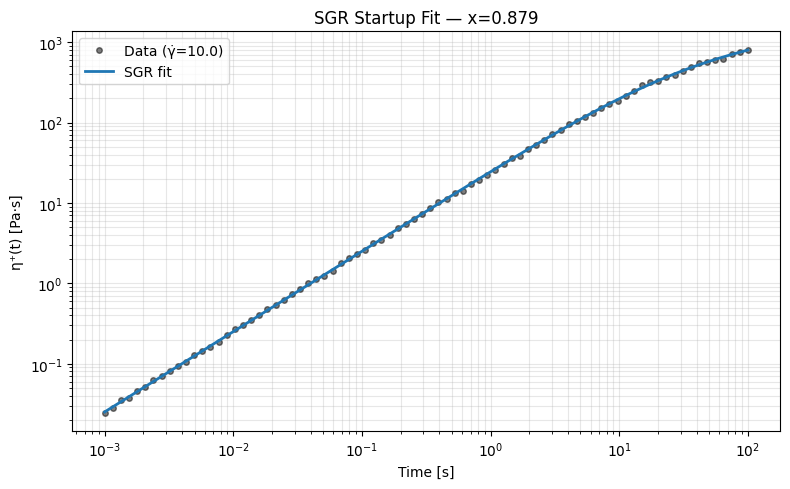

In [7]:
t_fine = np.logspace(-3, 2, 200)
model._startup_gamma_dot = gd_fit
eta_plus_pred = model.predict(t_fine)

fig, ax = plt.subplots(figsize=(8, 5))
ax.loglog(d["t"], d["eta_plus"], "ko", markersize=4, alpha=0.5, label=f"Data (γ̇={gd_fit})")
ax.loglog(t_fine, eta_plus_pred, "-", lw=2, color="C0", label="SGR fit")

x_fit = model.parameters.get_value("x")
ax.set_xlabel("Time [s]")
ax.set_ylabel("η⁺(t) [Pa·s]")
ax.set_title(f"SGR Startup Fit — x={x_fit:.3f}")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

### 4.2 Phase Regime Effect on Startup

Explore how the noise temperature x affects startup behavior across different phase regimes.

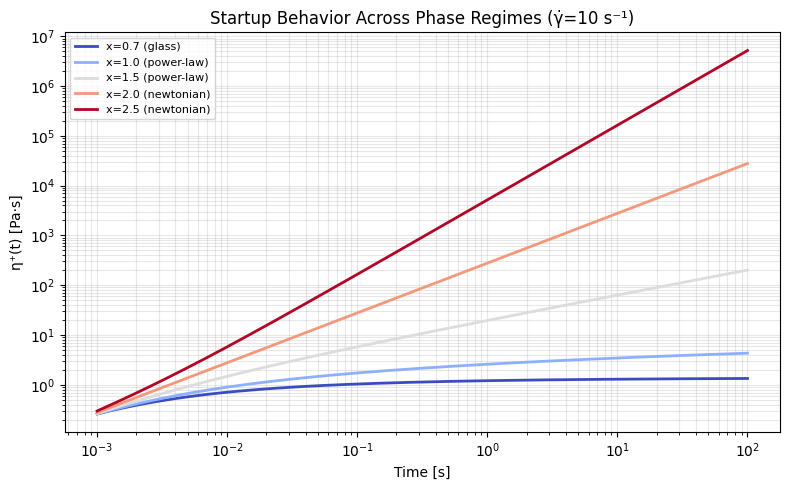

In [8]:
x_values = [0.7, 1.0, 1.5, 2.0, 2.5]
t_sweep = np.logspace(-3, 2, 200)

fig, ax = plt.subplots(figsize=(8, 5))
colors = plt.cm.coolwarm(np.linspace(0, 1, len(x_values)))

for i, x_val in enumerate(x_values):
    m = SGRConventional()
    m.parameters.set_value("x", x_val)
    m.parameters.set_value("G0", 500.0)
    m.parameters.set_value("tau0", 1e-3)
    m.fitted_ = True
    m._test_mode = "startup"
    m._startup_gamma_dot = 10.0

    eta_sweep = m.predict(t_sweep)
    regime = m.get_phase_regime()
    ax.loglog(t_sweep, eta_sweep, "-", color=colors[i], lw=2, label=f"x={x_val} ({regime})")

ax.set_xlabel("Time [s]")
ax.set_ylabel("η⁺(t) [Pa·s]")
ax.set_title("Startup Behavior Across Phase Regimes (γ̇=10 s⁻¹)")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Dynamic Noise Temperature

### 5.1 Thixotropic x(t) Evolution

With `dynamic_x=True`, the noise temperature x evolves under shear according to:

$$
\frac{dx}{dt} = -\alpha_{\text{aging}} \cdot (x - x_{\text{eq}}) + \beta_{\text{rejuv}} \cdot \dot{\gamma} \cdot (x_{\text{ss}} - x)
$$

where:

$$
x_{\text{ss}}(\dot{\gamma}) = x_{\text{eq}} + A \cdot (\dot{\gamma} \cdot \tau_0)^n
$$

This equation couples aging (structural recovery) and rejuvenation (shear-induced breakdown).

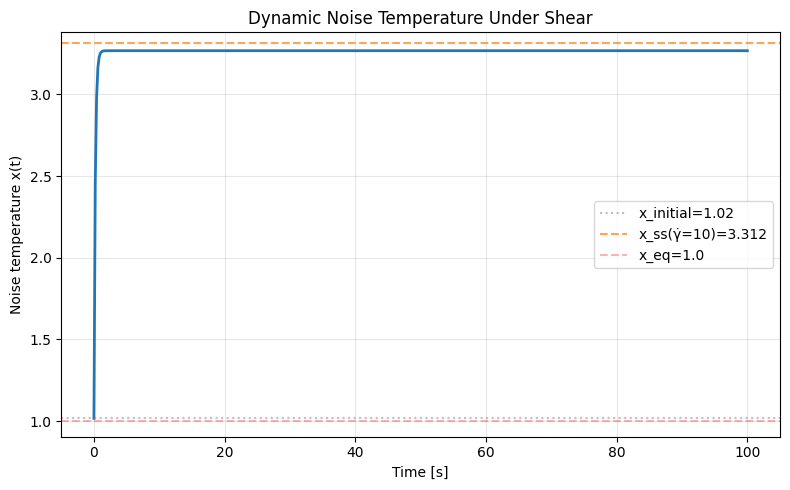

In [9]:
model_dyn = SGRConventional(dynamic_x=True)

# Set parameters
model_dyn.parameters.set_value("x", calib_params["x"])
model_dyn.parameters.set_value("G0", calib_params["G0"])
model_dyn.parameters.set_value("tau0", calib_params["tau0"])
model_dyn.parameters.set_value("x_eq", 1.0)
model_dyn.parameters.set_value("alpha_aging", 0.1)
model_dyn.parameters.set_value("beta_rejuv", 0.5)
model_dyn.parameters.set_value("x_ss_A", 0.5)
model_dyn.parameters.set_value("x_ss_n", 0.3)

# Evolve x under constant shear
t_evol = np.linspace(0, 100, 500)
gamma_dot_evol = np.full_like(t_evol, 10.0)  # Constant shear rate

x_trajectory = model_dyn.evolve_x(t_evol, gamma_dot_evol, x_initial=calib_params["x"])

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(t_evol, np.array(x_trajectory), "-", lw=2)
ax.axhline(calib_params["x"], color="gray", linestyle=":", alpha=0.5, label=f"x_initial={calib_params['x']:.2f}")

# Compute x_ss for this shear rate
tau0_val = calib_params["tau0"]
x_ss_val = 1.0 + 0.5 * (10.0 * tau0_val) ** 0.3
ax.axhline(x_ss_val, color="C1", linestyle="--", alpha=0.7, label=f"x_ss(γ̇=10)={x_ss_val:.3f}")
ax.axhline(1.0, color="red", linestyle="--", alpha=0.3, label="x_eq=1.0")

ax.set_xlabel("Time [s]")
ax.set_ylabel("Noise temperature x(t)")
ax.set_title("Dynamic Noise Temperature Under Shear")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

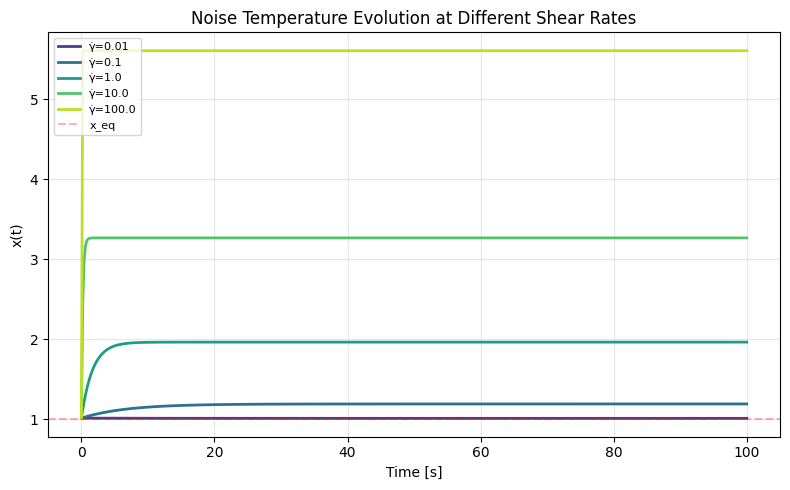

In [10]:
fig, ax = plt.subplots(figsize=(8, 5))
gd_values = [0.01, 0.1, 1.0, 10.0, 100.0]
colors = plt.cm.viridis(np.linspace(0.2, 0.9, len(gd_values)))

for i, gd in enumerate(gd_values):
    gamma_dot_arr = np.full_like(t_evol, gd)
    x_traj = model_dyn.evolve_x(t_evol, gamma_dot_arr, x_initial=calib_params["x"])
    ax.plot(t_evol, np.array(x_traj), "-", color=colors[i], lw=2, label=f"γ̇={gd}")

ax.axhline(1.0, color="red", linestyle="--", alpha=0.3, label="x_eq")
ax.set_xlabel("Time [s]")
ax.set_ylabel("x(t)")
ax.set_title("Noise Temperature Evolution at Different Shear Rates")
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3)
plt.tight_layout()
display(fig)
plt.close(fig)

Higher shear rates drive x further from equilibrium (rejuvenation dominates), while at rest, aging pulls x back toward x_eq. This is the SGR mechanism for thixotropy.

## 6. Bayesian Inference

### 6.1 Run NUTS

**Important**: For startup mode, set `model._startup_gamma_dot` before calling `fit_bayesian()`.

In [11]:
initial_values = {name: model.parameters.get_value(name) for name in ["x", "G0", "tau0"]}
print("Warm-start values:", initial_values)

# Ensure startup gamma_dot is set
model._startup_gamma_dot = gd_fit

NUM_WARMUP = 200
NUM_SAMPLES = 500
NUM_CHAINS = 1
# NUM_WARMUP = 1000; NUM_SAMPLES = 2000; NUM_CHAINS = 4  # production

t0 = time.time()
result = model.fit_bayesian(
    d["t"], d["eta_plus"], test_mode="startup",
    num_warmup=NUM_WARMUP, num_samples=NUM_SAMPLES, num_chains=NUM_CHAINS,
    initial_values=initial_values, seed=42,
)
t_bayes = time.time() - t0
print(f"\nBayesian inference time: {t_bayes:.1f} s")

Warm-start values: {'x': 0.8793816783603792, 'G0': 32.15551989682252, 'tau0': 19.481113423377266}


  0%|          | 0/700 [00:00<?, ?it/s]

warmup:   0%|          | 1/700 [00:00<05:14,  2.22it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   3%|▎         | 24/700 [00:00<00:11, 56.78it/s, 63 steps of size 2.50e-03. acc. prob=0.87]

warmup:   6%|▌         | 40/700 [00:00<00:08, 81.54it/s, 287 steps of size 2.17e-03. acc. prob=0.91]

warmup:   8%|▊         | 58/700 [00:00<00:06, 106.28it/s, 127 steps of size 1.68e-03. acc. prob=0.92]

warmup:  12%|█▏        | 82/700 [00:00<00:04, 141.59it/s, 71 steps of size 1.29e-03. acc. prob=0.93] 

warmup:  14%|█▍        | 101/700 [00:00<00:04, 145.49it/s, 1023 steps of size 1.30e-02. acc. prob=0.94]

warmup:  17%|█▋        | 119/700 [00:01<00:03, 150.04it/s, 255 steps of size 1.86e-02. acc. prob=0.95] 

warmup:  20%|█▉        | 138/700 [00:01<00:03, 153.92it/s, 351 steps of size 1.48e-02. acc. prob=0.95]

warmup:  23%|██▎       | 158/700 [00:01<00:03, 165.72it/s, 135 steps of size 7.40e-03. acc. prob=0.95]

warmup:  26%|██▌       | 179/700 [00:01<00:02, 175.77it/s, 495 steps of size 9.83e-03. acc. prob=0.96]

warmup:  28%|██▊       | 198/700 [00:01<00:02, 177.76it/s, 127 steps of size 1.29e-02. acc. prob=0.96]

sample:  31%|███       | 217/700 [00:01<00:02, 177.25it/s, 135 steps of size 1.14e-02. acc. prob=0.99]

sample:  34%|███▎      | 236/700 [00:01<00:02, 172.69it/s, 39 steps of size 1.14e-02. acc. prob=0.99] 

sample:  36%|███▋      | 254/700 [00:01<00:02, 167.00it/s, 271 steps of size 1.14e-02. acc. prob=0.99]

sample:  39%|███▉      | 274/700 [00:01<00:02, 175.90it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  42%|████▏     | 295/700 [00:02<00:02, 182.92it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  45%|████▍     | 314/700 [00:02<00:02, 159.04it/s, 351 steps of size 1.14e-02. acc. prob=0.99]

sample:  47%|████▋     | 331/700 [00:02<00:02, 154.47it/s, 191 steps of size 1.14e-02. acc. prob=0.99]

sample:  50%|████▉     | 347/700 [00:02<00:02, 149.59it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  52%|█████▏    | 367/700 [00:02<00:02, 159.09it/s, 447 steps of size 1.14e-02. acc. prob=0.99]

sample:  55%|█████▍    | 384/700 [00:02<00:02, 136.60it/s, 127 steps of size 1.14e-02. acc. prob=0.99]

sample:  57%|█████▋    | 399/700 [00:02<00:02, 131.71it/s, 127 steps of size 1.14e-02. acc. prob=0.99]

sample:  60%|█████▉    | 418/700 [00:02<00:01, 144.76it/s, 319 steps of size 1.14e-02. acc. prob=0.99]

sample:  63%|██████▎   | 443/700 [00:03<00:01, 171.07it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  66%|██████▋   | 464/700 [00:03<00:01, 178.57it/s, 511 steps of size 1.14e-02. acc. prob=0.99]

sample:  69%|██████▉   | 483/700 [00:03<00:01, 165.97it/s, 383 steps of size 1.14e-02. acc. prob=0.99]

sample:  72%|███████▏  | 502/700 [00:03<00:01, 171.06it/s, 415 steps of size 1.14e-02. acc. prob=0.99]

sample:  74%|███████▍  | 520/700 [00:03<00:01, 166.96it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  77%|███████▋  | 538/700 [00:03<00:01, 145.32it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  79%|███████▉  | 554/700 [00:03<00:01, 131.03it/s, 199 steps of size 1.14e-02. acc. prob=0.99]

sample:  82%|████████▏ | 571/700 [00:03<00:00, 138.87it/s, 319 steps of size 1.14e-02. acc. prob=0.99]

sample:  86%|████████▌ | 600/700 [00:04<00:00, 174.13it/s, 511 steps of size 1.14e-02. acc. prob=0.99]

sample:  90%|█████████ | 631/700 [00:04<00:00, 209.07it/s, 483 steps of size 1.14e-02. acc. prob=0.99]

sample:  93%|█████████▎| 654/700 [00:04<00:00, 210.71it/s, 255 steps of size 1.14e-02. acc. prob=0.99]

sample:  98%|█████████▊| 685/700 [00:04<00:00, 238.05it/s, 7 steps of size 1.14e-02. acc. prob=0.99]  

sample: 100%|██████████| 700/700 [00:04<00:00, 158.29it/s, 351 steps of size 1.14e-02. acc. prob=0.99]


Bayesian inference time: 8.7 s


### 6.2 Convergence Diagnostics

In [12]:
diag = result.diagnostics
param_names = ["x", "G0", "tau0"]

print("Convergence Diagnostics")
print("=" * 50)
print(f"{'Parameter':>10s}  {'R-hat':>8s}  {'ESS':>8s}")
print("-" * 50)
for p in param_names:
    r_hat = diag.get("r_hat", {}).get(p, float("nan"))
    ess = diag.get("ess", {}).get(p, float("nan"))
    print(f"{p:>10s}  {r_hat:8.4f}  {ess:8.0f}")
n_div = diag.get("divergences", diag.get("num_divergences", 0))
print(f"\nDivergences: {n_div}")

Convergence Diagnostics
 Parameter     R-hat       ESS
--------------------------------------------------
         x    1.0000       500
        G0    1.0000       500
      tau0    1.0000       500

Divergences: 0


### 6.3 ArviZ Plots

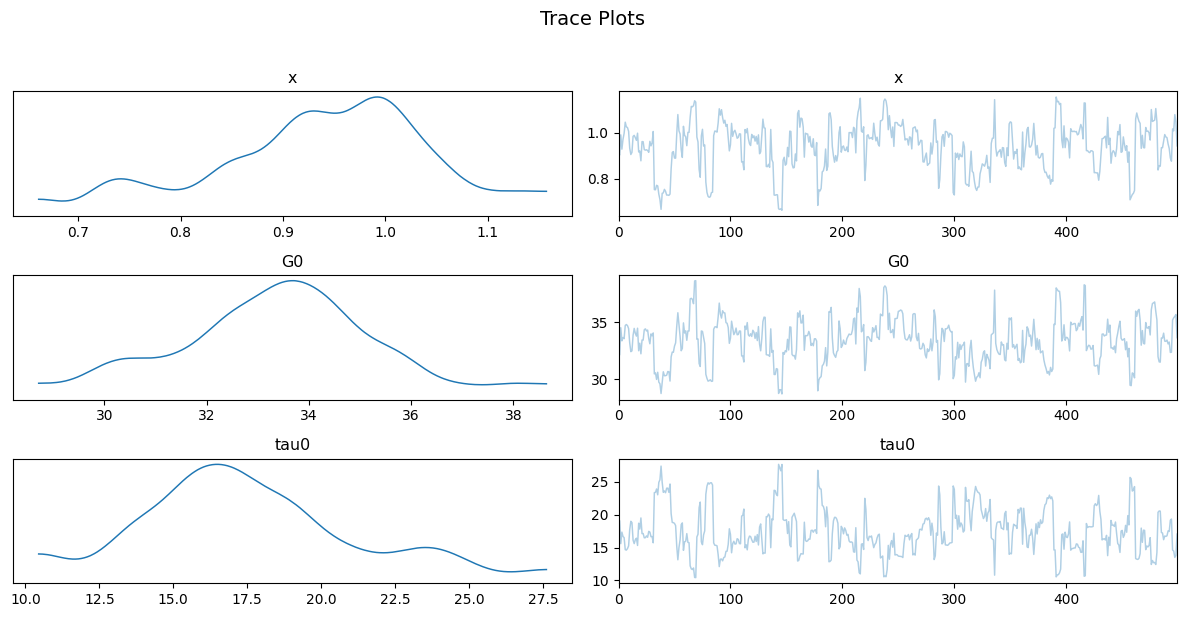

In [13]:
idata = result.to_inference_data()
axes = az.plot_trace(idata, var_names=param_names, figsize=(12, 6))
fig = axes.ravel()[0].figure
fig.suptitle("Trace Plots", fontsize=14, y=1.02)
plt.tight_layout()
display(fig)
plt.close(fig)

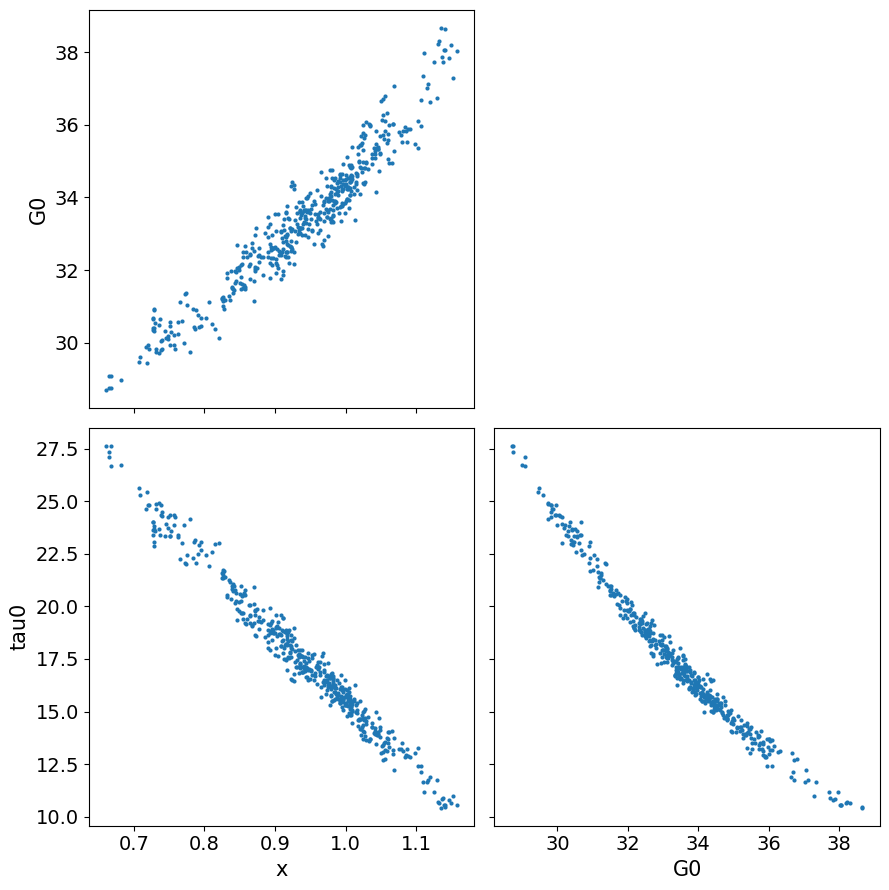

In [14]:
axes = az.plot_pair(idata, var_names=param_names, kind="scatter", divergences=True, figsize=(9, 9))
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

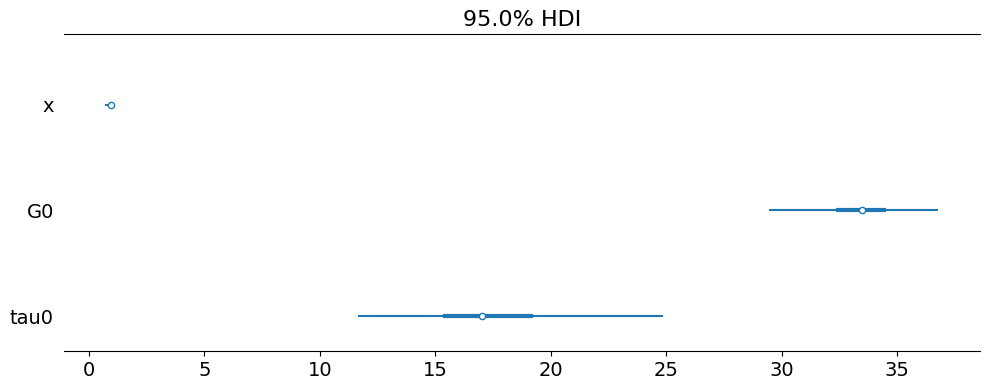

In [15]:
axes = az.plot_forest(idata, var_names=param_names, combined=True, hdi_prob=0.95, figsize=(10, 4))
fig = axes.ravel()[0].figure
plt.tight_layout()
display(fig)
plt.close(fig)

### 6.4 Posterior Predictive

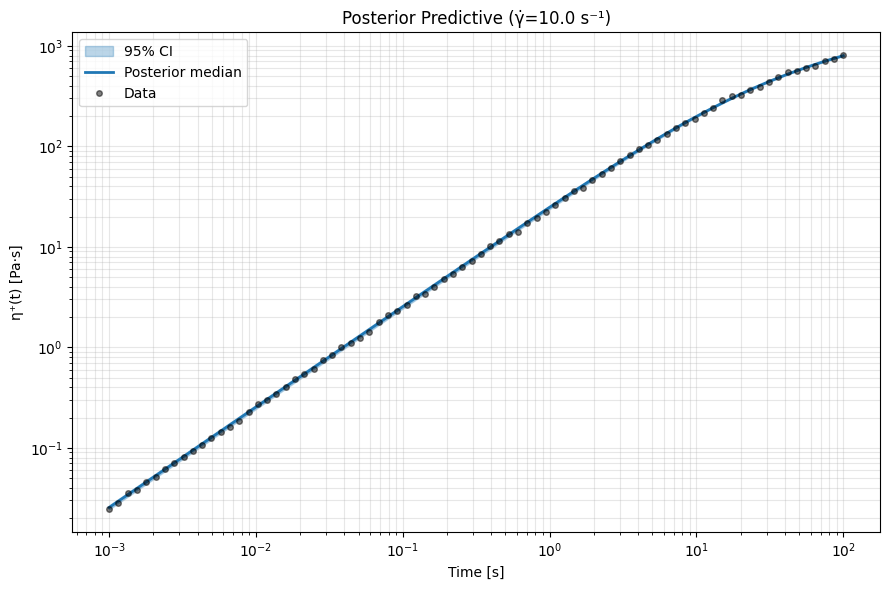

In [16]:
posterior = result.posterior_samples
n_draws = min(200, len(list(posterior.values())[0]))
t_pred = np.logspace(-3, 2, 100)

pred_samples = []
for i in range(n_draws):
    # Set parameters from posterior
    for name in ["x", "G0", "tau0"]:
        model.parameters.set_value(name, float(posterior[name][i]))
    pred_i = model.predict(t_pred, test_mode="startup", gamma_dot=gd_fit)
    pred_samples.append(np.array(pred_i))

pred_samples = np.array(pred_samples)
pred_median = np.median(pred_samples, axis=0)
pred_lo = np.percentile(pred_samples, 2.5, axis=0)
pred_hi = np.percentile(pred_samples, 97.5, axis=0)

fig, ax = plt.subplots(figsize=(9, 6))
ax.fill_between(t_pred, pred_lo, pred_hi, alpha=0.3, color="C0", label="95% CI")
ax.loglog(t_pred, pred_median, "-", lw=2, color="C0", label="Posterior median")
ax.loglog(d["t"], d["eta_plus"], "ko", markersize=4, alpha=0.5, label="Data")
ax.set_xlabel("Time [s]")
ax.set_ylabel("η⁺(t) [Pa·s]")
ax.set_title(f"Posterior Predictive (γ̇={gd_fit} s⁻¹)")
ax.legend()
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 7. Save Results

In [17]:
output_dir = os.path.join("..", "outputs", "sgr", "startup")
os.makedirs(output_dir, exist_ok=True)

nlsq_params = {name: float(model.parameters.get_value(name)) for name in ["x", "G0", "tau0"]}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(nlsq_params, f, indent=2)

posterior_dict = {k: np.array(v).tolist() for k, v in posterior.items()}
with open(os.path.join(output_dir, "posterior_samples.json"), "w") as f:
    json.dump(posterior_dict, f)

print(f"Results saved to {output_dir}/")

Results saved to ../outputs/sgr/startup/


## Key Takeaways

1. **SGR startup**: η⁺(t) shows power-law growth with exponent (x-1) encoding the phase regime
2. **Glass regime (x < 1)**: η⁺ diverges (no steady state), material cannot flow
3. **Fluid regime (x > 1)**: η⁺ saturates to zero-shear viscosity η₀
4. **Dynamic x mode**: Enables thixotropic aging/rejuvenation via `evolve_x()` method
5. **Shear rate dependence**: Higher γ̇ pushes x further from equilibrium (mechanical rejuvenation)
6. **Bayesian inference**: Must set `model._startup_gamma_dot` before `fit_bayesian()` for correct predictions
7. **Model limitation**: SGRGeneric does not support startup mode — use SGRConventional only

### Next Steps

- **Notebook 06**: LAOS (large amplitude oscillatory shear) for nonlinear response
- Explore multi-shear-rate fitting with simultaneous estimation of x, G₀, τ₀
- Investigate dynamic_x parameter estimation from startup transients